<a href="https://colab.research.google.com/github/emiliomercuri/MACC/blob/main/codes/2023_10_03_Kaczmarski_UPDF_v03(variando_porosidade_aparente).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Método numérico de solução do reator de captura de CO2

### Equações das constantes calculadas pelo Tarcisio

Juntamos os códigos

#### Modelo acoplado considerando as equações do Fluido intersticial e dos Pellets empacotados

Baseado nos artigos:

* Kaczmarski, K., & Szukiewicz, M. K. (2021). An efficient and robust method for numerical analysis of a dead zone in catalyst particle and packed bed reactor. Engineering Reports, 3(8), e12370.

* Chen-Charpentier, B. M., & Kojouharov, H. V. (2013). An unconditionally positivity preserving scheme for advection–diffusion reaction equations. Mathematical and computer modelling, 57(9-10), 2177-2185.


Variáveis:
* $y_i^{n}$: Concentração de CO$_2$ na fase gasosa (função de x e t)
* $c_{j,i}^{n}$: Concentração de CO$_2$ nos Pellets (fase sólida) (função de R, x e t)

Índices:
* $n$ - tempo $t$
* $i$ - posição axial $x$ do reator
* $j$ - posição radial $R$ dentro do Pellet

\begin{equation}
 	y_i^{n+1}
 	=
 	\frac{
 	\widehat{\rm Pe}  \, y_{i+1}^n +
 	y_i^n  / \Delta t  +
 	\left( 1 / \Delta x   +
 	\widehat{\rm Pe}    \right)  y_{i-1}^n  +
 	A  \, c_{i,j}^n
 	}{
 	1 / \Delta t +
 	1 / \Delta x +
 	2 \widehat{\rm Pe}   +
 	A }
\end{equation}


Condições de contorno (em $x$ temos os índices $i = 0...m$):

* $y_{0}^{n} = y_f$ e $y_1^{n} = y_f$
* $y_m^{n} = y_{m-1}^{n}$


\begin{equation}
 	c_{j,i}^{n+1}
 	=
 	\frac{
 	\left( \frac{\Delta R \, \Delta t \, E}{R_d+ F R_j}  +
 	\Delta t \, B
 	\right) c_{j+1,i}^{n} +
 	\Delta R^2 c_{j,i}^n +
 	\Delta t \, B \, c_{j-1,i}^n
 	}{
 	\left(
 	\Delta R^2 +
 	\frac{\Delta R \, \Delta t \, E}{R_d+ F R_j} +
 	2 \Delta t \, B +
 	\Delta R^2 \, \Delta t \, G
 	\right)
 	}
 \end{equation}

Condições de contorno (em $R$ temos os índices $j = 0...k$):

*	$c_{k,i}^{n}   = (\mathrm{Bi} \, \Delta R \,  y_{i}^{n}  + c_{k-1,i}^n ) / (1 + \mathrm{Bi} \, \Delta R )$
* $c_{0,i}^{n} = c_{1,i}^n$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math

from numpy import zeros, linspace, ones

## Cálculos do Tarcisio

* Basedos no livro do Bird (Fenômenos de tranporte) e artigo Dantas e colaboradores (2011)

In [ ]:
# Defining Ergun Equation
def Ergun(u):
    return (DeltaP / (rho_g * u ** 2)) * (d_p / L) * (eps_bed ** 3 / (1 - eps_bed)) -\
        150 * ((1 - eps_bed) / (d_p * rho_g * u / mu_g)) - (7 / 4)

# Feed data
y_CO2 = 0.14
y_N2 = 1 - y_CO2
T = 298.15  # [K]
p_abs = 1  # [atm]
p_in_rel = 100 / 101325  # input em Pa e transformar para atm [atm]
p_in_abs = p_in_rel + p_abs  # [atm]
M_CO2 = 44.01  # [g mol-1]
M_N2 = 28.01  # [g mol-1]
M_g = y_CO2 * M_CO2 + y_N2 * M_N2  # [g mol-1]
# Densidade mássica do CO2
rho_CO2 = (p_in_abs * 101325) * (M_CO2 / 1000) / (8.314 * T)  # [kg m-3]
print(f"rho_CO2: {rho_CO2:.4f} [kg m-3]")
# Densidade mássica do N2
rho_N2 = (p_in_abs * 101325) * (M_N2 / 1000) / (8.314 * T)  # [kg m-3]
# Densidade mássica da mistura
rho_g = (y_CO2 / M_CO2) / (y_CO2 / M_CO2 + y_N2 / M_N2) * rho_CO2 + \
        (y_N2 / M_N2) / (y_CO2 / M_CO2 + y_N2 / M_N2) * rho_N2  # [kg m-3]

# Packed bed data
# Porosidade do leito
eps_bed = 0.5
# Diâmetro do leito
D_bed = 0.1                                                                                                 # [m]
# Comprimento do reator
L = 0.3                                                                                                     # [m]
# Área da seção transversal
A_bed = math.pi * (D_bed / 2)**2                                                                            # [m2]

# Particle data
# Diâmetro da partícula
d_p = 0.0025                                                                                                # [m]
# Tortuosidade
tau = 2.2 #tortuosity
# Diâmetro dos poros
d_pore = 2.46                                                                                               # [nm]

# Lennard Jones data
# Tamanho da molécula de CO2 em Angstron
sig_CO2 = 3.9996                                                                                            # [A]
# Tamanho da molécula de N2 em Angstron
sig_N2 = 3.667                                                                                              # [A]
# Epsilon sobre k para o CO2 (Parâmetro de Lennard Jones -> ver Bird (Fenômenos de Transporte))
ek_CO2 = 190
# Epsilon sobre k para o N2 (Parâmetro de Lennard Jones -> ver Bird (Fenômenos de Transporte))
ek_N2 = 99.8
# kappa * Temperatura (K) / Epsilon para CO2
kTe_CO2 = 1 / ek_CO2 * T
# kappa * Temperatura (K) / Epsilon para N2
kTe_N2 = 1 / ek_N2 * T
# Integral de colisão (Omega) para viscosidade do CO2
omg_mu_CO2 = 1.16145 / kTe_CO2**0.14874 + 0.52487 / \
    math.exp(0.77320 * kTe_CO2) + 2.16178 / math.exp(2.43787 * kTe_CO2)
# Integral de colisão (Omega) para viscosidade do N2
omg_mu_N2 = 1.16145 / kTe_N2**0.14874 + 0.52487 / \
    math.exp(0.77320 * kTe_N2) + 2.16178 / math.exp(2.43787 * kTe_N2)

# Viscosity estimation (Lennard Jones equation)
mu_CO2 = 2.6693e-5 * math.sqrt(M_CO2 * T) / (sig_CO2**2 * omg_mu_CO2)
mu_N2 = 2.6693e-5 * math.sqrt(M_N2 * T) / (sig_N2**2 * omg_mu_N2)

# Viscosity binary mixture estimation (Wilke Equation)
phi_aa = 1 / math.sqrt(8) * (1 + M_CO2 / M_CO2)**(-0.5) * \
    (1 + (mu_CO2 / mu_CO2)**0.5 * (M_CO2 / M_CO2)**0.25)**2
phi_ab = 1 / math.sqrt(8) * (1 + M_CO2 / M_N2)**(-0.5) * \
    (1 + (mu_CO2 / mu_N2)**0.5 * (M_CO2 / M_N2)**0.25)**2
phi_ba = 1 / math.sqrt(8) * (1 + M_N2 / M_CO2)**(-0.5) * \
    (1 + (mu_N2 / mu_CO2)**0.5 * (M_N2 / M_CO2)**0.25)**2
phi_bb = 1 / math.sqrt(8) * (1 + M_N2 / M_N2)**(-0.5) * \
    (1 + (mu_N2 / mu_N2)**0.5 * (M_N2 / M_N2)**0.25)**2
# Viscosidade da Mistura
mu_g = y_CO2 * mu_CO2 / (y_CO2 * phi_aa + y_N2 * phi_ab) + \
    y_N2 * mu_N2 / (y_N2 * phi_bb + y_CO2 * phi_ba)  # [g cm-1 s-1]

# Molecular diffusivity estimation (Chapman-Enskog Equation)
sig_ab = 0.5 * (sig_CO2 + sig_N2)
eab_k = math.sqrt(ek_CO2 * ek_N2)
kTe_ab = 1 / eab_k * T
omg_Dab = 1.06036 / kTe_ab**0.15610 + 0.19300 / math.exp(0.47635 * kTe_ab) + \
    1.03587 / math.exp(1.52996 * kTe_ab) + 1.76474 / math.exp(3.894117 * kTe_ab)
# Difusividade Molecular
Dab = 1.8583e-3 * math.sqrt(T**3 * (1 / M_CO2 + 1 / M_N2)) * 1 / \
    (p_in_abs * sig_ab**2 * omg_Dab) * 1e-4                                                                        # [m2 s-1]

# Effective diffusivity estimation
lam_ab = 8.3144e7 * T / (6.023e23 * math.sqrt(2) * math.pi * (sig_ab * 1e-8)**2 * (p_in_abs * 1.01325e6)) * 1e7    # [nm]
Dk = 4.85e3 * d_pore * 1e-7 * (T / (y_CO2 * M_CO2 + y_N2 * M_N2))**0.5 * 1e-4                               # [m2 s-1]
Deff = (tau * (1 / Dab + 1 / Dk))**(-1)                                                                     # [m2 s-1]

# Velocity estimation by Ergun Equation
DeltaP = p_in_rel * 101325  # Considerando P_out_abs = P_abs e transformando a unidade de atm para Pa
u0 = 0.001
u_avg = fsolve(Ergun, u0)
u_avg = u_avg.item() #Transformar u_avg de numpy.ndarray para float

# Dimensionless numbers estimation
Re_d = d_p*u_avg * rho_g / mu_g
Pe = 0.508 * Re_d**0.020 * (L / d_p)
Sc = (mu_g * 10) / (rho_g * Dab)
Sh = 1.09 * Re_d**0.27 * Sc**(1 / 3)
DL = u_avg * L / Pe                                                                                         # [m2 s-1]
kf = Sh * Dab / d_p                                                                                         # [m s-1]

# Permeability Kozeny-Carman equation
phi_sph = 1  # [sphericity] of the particles in the packed bed = 1 for spherical particles
k_bed = phi_sph**2 * eps_bed**3 * d_p**2 / (180 * (1 - eps_bed)**2)

# Clearing variables that are no longer needed
del ek_N2, ek_CO2, M_CO2, M_N2, phi_sph, sig_ab, sig_N2, sig_CO2, tau

print(f"P: {p_in_abs:.4f} atm")
print(f"T: {T:.2f} K")
print(f"mu_g: {mu_g/10:.4e} Pa s")
print(f"u_avg: {u_avg:.4f} m s-1")
print(f"Dab: {Dab:.4e} m2 s-1")
print(f"Dk: {Dk:.4e} m2 s-1")
print(f"Deff: {Deff:.4e} m2 s-1")
print(f"DL: {DL:.4e} m2 s-1")
print(f"kf: {kf:.4e} m2 s-1")
print(f"kappa_bed: {k_bed:.4e} m2")

rho_CO2: 1.8007 [kg m-3]
P: 1.0010 atm
T: 298.15 K
mu_g: 1.7093e-05 Pa s
u_avg: 0.0400 m s-1
Dab: 1.5018e-05 m2 s-1
Dk: 3.7457e-07 m2 s-1
Deff: 1.6612e-07 m2 s-1
DL: 1.9807e-04 m2 s-1
kf: 2.7125e-02 m2 s-1
kappa_bed: 1.7361e-08 m2


\begin{equation}
 	y_i^{n+1}
 	=
 	\frac{
 	\widehat{\rm Pe}  \, y_{i+1}^n +
 	y_i^n  / \Delta t  +
 	\left( 1 / \Delta x   +
 	\widehat{\rm Pe}    \right)  y_{i-1}^n  +
 	A \, y_p
 	}{
 	1 / \Delta t +
 	1 / \Delta x +
 	2 \widehat{\rm Pe}   +
 	A }
\end{equation}

\begin{equation}
 	y_i^{n+1}
 	=
 	\frac{
 	\widehat{\rm Pe}  \, y_{i+1}^n +
 	y_i^n  / \Delta t  +
 	\left( 1 / \Delta x   +
 	\widehat{\rm Pe}    \right)  y_{i-1}^n  +
 	A \, y_p
 	}{
 	1 / \Delta t +
 	1 / \Delta x +
 	2 \widehat{\rm Pe}   +
 	A }
\end{equation}

In [ ]:
# Concentração do fluido de entrada
y_f = rho_CO2
print(y_f)

1.8007422364947896


Variáveis auxiliares:

* $B = \frac{1}{\varepsilon_p} \frac{ \mathrm{St}}{(\alpha+1) \mathrm{Bi}} \frac{R_p^2}{\left(R_p-R_d\right)^2} $
* $E = \frac{1}{\varepsilon_p} \frac{ \mathrm{St}}{(\alpha+1) \mathrm{Bi}}  \alpha\left(R_p-R_d\right)  \frac{R_p^2}{\left(R_p-R_d\right)^2}	= B \alpha\left(R_p-R_d\right)$
* $F = \left(R_p-R_d\right)$
* $G = \frac{\left(1-\varepsilon_p\right)}{\varepsilon_p}  \frac{\Phi^2 \mathrm{St}}{(\alpha+1) \mathrm{Bi}}$

NOVA Variável auxiliar:

* $Z_i = (\Delta R \, \Delta t \, E) / (R_d+ F \, r_j)$

\begin{equation}
 	c_{j,i}^{n+1}
 	=
 	\frac{
 	\left( Z_i  +
 	\Delta t \, B
 	\right) c_{j+1,i}^{n} +
 	\Delta R^2 c_{j,i}^n +
 	\Delta t \, B \, c_{j-1,i}^n
 	}{
 	\left(
 	\Delta R^2 +
 	Z_i +
 	2 \Delta t \, B +
 	\Delta R^2 \, \Delta t \, G
 	\right)
 	}
 \end{equation}

Condições de contorno (em $R$ temos os índices $j = 0...k$):

*	$c_{k,i}^{n}   = (\mathrm{Bi} \, \Delta R \,  y_{i}^{n}  + c_{k-1,i}^n ) / (1 + \mathrm{Bi} \, \Delta R )$
* $c_{0,i}^{n} = c_{1,i}^n$


In [ ]:
# Variação da porosidade da partícula
print(len(np.arange(0.1,0.7,0.1)))

np.arange(0.1,0.7,0.1)

6


array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [ ]:
eps_bed

0.5

In [ ]:
# Raio da Partícula
Rp = d_p/2 # m

dx = 0.01
dr = Rp/10
dt = 0.004
T = 20.0
# L foi definido pelo Tarcísio
R = D_bed/2
nx = int(L/dx)    # L = tamanho do domínio no espaço
nt = int(T/dt)     # T = tamanho do domínio no tempo
nr = int(Rp/dr)    # R = raio adimensional do pellet

x = linspace(0.0,L,nx+1)
# print(len(x))
# print(x)

r = linspace(0.0,R,nr+1)
# print(len(r))
# print(r)

t = linspace(0.0,T,nt+1)
# print(len(t))
# print(t)

# Concentração no Pellet
c = zeros((nt+1,nr+1,nx+1,9),float)
# Concentração no fluido
y = zeros((nt+1,nx+1,9),float)

In [ ]:
cont = 0
for epsilon_e in np.arange(0.1,0.9,0.1):
  print(epsilon_e,cont)

  # Condição inicial para y (gás) e c (pellet)
  y0 = rho_CO2
  c0 = 0

  # Velocidade média do escoamento no leito do reator
  u = u_avg # m/s Referência Tarcísio (equações acima)

  # Coeficiente de Dispersão
  D_L = DL # m2 s-1

  # Coeficiente de Difusão Efetivo (Está faltando explicar o que é Dm no artigo de Kaczmarski Szukievicz)
  # O Deff foi calculado pelo Tarcísio acima.

  # Porosidade aparente
  #epsilon_e = eps_bed # Referência Tarcísio (##### Vamos variar! )

  # Porosidade da partícula
  epsilon_p = 0.3 # Falta Referência

  # coeficiente de transferência de massa externa
  k_ext = kf/1000 # m2 s-1

  # taxa da reação cinética
  k_rea = 1000.0

  # Raio da zona morta
  Rd = 0

  # geometria da partícula que pode ser esférica, cilíndrica ou uma placa (2, 1 ou 0, respectivamente)
  alpha = 2 # (esfera)

  # constante
  a_p = (alpha + 1)/Rp

  # Número de Peclet
  Pe = u*L/(D_L*epsilon_e)

  # Número de Peclet chapeu
  Pe_c = 1/(Pe*dx**2)

  # Número de Stanton
  St = k_ext*a_p*L*epsilon_e/u

  # Constante
  A = St*(1-epsilon_e)/epsilon_e

  # Número de Biot
  Bi = k_ext*Rp/Deff

  # Módulo de Thiele ao quadrado
  phi2 = (Rp**2)*k_rea/Deff

  B = St*Rp**2 / (epsilon_p * (alpha+1) * Bi * (Rp-Rd)**2)
  E = B * alpha * (Rp-Rd)
  F = (Rp-Rd)
  G = (1-epsilon_p) * phi2 * St / (epsilon_p * (alpha+1) * Bi)


  for n in range(nt-1):
      #print(n)
      tn = n*dt
      # condições de contorno para y (CO2 no gas)
      y[n,0,cont] = y_f
      y[n,1,cont] = y_f
      y[n,nx,cont] = y[n,nx-1,cont]
      for i in range(1,nx):
          xi = i*dx
          y[n+1,i,cont] = (Pe_c*y[n,i+1,cont]+y[n,i,cont]/dt+(1/dx+Pe_c)*y[n,i-1,cont]+A*c[n,nr,i,cont])/(1/dt+1/dx+2*Pe_c+A)
          # condições de contorno para c (CO2 no pellet)
          c[n,0,i,cont] = c[n,1,i,cont]
          c[n,nr,i,cont] = (Bi*dr*y[n,i,cont] + c[n,nr-1,i,cont])/(1+Bi*dr)
          for j in range(1,nr):
            ri = j*dr
            Zi = (dr * dt * E) / (Rd + F * ri)
            c[n+1,j,i,cont] = ((Zi+dt*B) * c[n,j+1,i,cont] + (dr**2) * c[n,j,i,cont] + dt * B * c[n,j-1,i,cont]) / (dr**2 + Zi + 2*dt*B + (dr**2)*dt*G)

  cont += 1

0.1 0
0.2 1
0.30000000000000004 2
0.4 3
0.5 4
0.6 5
0.7000000000000001 6
0.8 7


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
t, len(t)

(array([0.0000e+00, 4.0000e-03, 8.0000e-03, ..., 1.9992e+01, 1.9996e+01,
        2.0000e+01]),
 5001)

In [ ]:
# plt.figure(figsize=(8, 6))

# plt.xlim([0,0.3])
# #plt.ylim([0,2.0])
# plt.title('Reator 1D - Concentração de CO2 no fluido', fontsize=18)
# plt.xlabel('L (comprimento do reator)', fontsize=16)
# plt.ylabel('y(t,x)', fontsize=16)
# plt.tick_params(axis='both', labelsize=16) #increase font size for ticks


# plt.plot(x,y[0,:], label="Tempo: 0.00")
# #plt.plot(x,y[1,:], label="Tempo: "+str(t[1]))
# #plt.plot(x,y[3,:], label="Tempo: "+str(t[3]))
# plt.plot(x,y[10,:], label="Tempo: "+str(t[10]))
# #plt.plot(x,y[50,:], label="Tempo: "+str(t[50]))
# #plt.plot(x,y[80,:], label="Tempo: "+str(t[80]))
# plt.plot(x,y[100,:], label="Tempo: "+str(t[100]))
# plt.plot(x,y[500,:], label="Tempo: "+str(t[500]))
# #plt.plot(x,y[900,:], label="Tempo: "+str(t[900]))
# plt.plot(x,y[900,:], label="Tempo: "+str(t[900]))
# plt.plot(x,y[900,:], label="Tempo: "+str(t[2000]))
# #plt.plot(x,y[2000,:], label="Tempo: "+str(t[2000]))
# # plt.plot(x,y[8000,:], label="Tempo: "+str(t[8000]))
# # plt.plot(x,y[10000,:], label="Tempo: "+str(t[10000]))
# #plt.plot(x,y[39999,:], label="Tempo: "+str(t[40000]))

# plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=14)


# # Show the plot
# #plt.savefig('Conc_CO2_fluido.png', dpi = 100, bbox_inches='tight')
# #plt.savefig('Conc_CO2_fluido.pdf', dpi = 600, bbox_inches='tight')
# plt.savefig('Conc_CO2_fluido.png', dpi = 600, bbox_inches='tight')
# plt.show();

In [ ]:
# plt.figure(figsize=(8, 6))

# plt.xlim([0,0.06])
# #plt.ylim([0,2.0])
# plt.title('Reator 1D - Concentração de CO2 no Pellet (no início do reator 10%)', fontsize=18)
# plt.xlabel('Raio (r)', fontsize=18)
# plt.ylabel('c(t,r,x=10%)', fontsize=18)
# plt.tick_params(axis='both', labelsize=16) #increase font size for ticks


# plt.plot(r,c[0,:,10], label="Tempo: 0.00")
# plt.plot(r,c[10,:,10], label="Tempo: "+str(t[10]))
# plt.plot(r,c[100,:,10], label="Tempo: "+str(t[100]))
# plt.plot(r,c[500,:,10], label="Tempo: "+str(t[500]))
# plt.plot(r,c[900,:,10], label="Tempo: "+str(t[900]))
# plt.plot(r,c[2000,:,10], label="Tempo: "+str(t[2000]))
# #plt.plot(r,c[10000,:,10], label="Tempo: "+str(t[10000]))
# #plt.plot(r,c[39998,:,10], label="Tempo: "+str(t[40000]))
# #plt.legend(loc='best');

# plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=14)

# # Show the plot
# #plt.savefig('Conc_CO2_pellet.png', dpi = 100, bbox_inches='tight')
# plt.savefig('Conc_CO2_pellet.png', dpi = 600, bbox_inches='tight')
# plt.show();

### Curva de Ruptura

Porosidade aparente
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

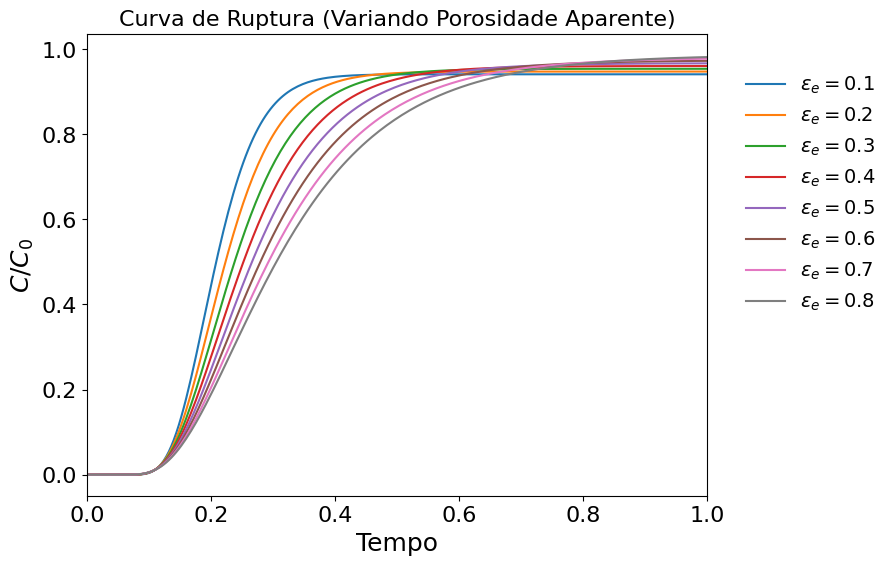

In [ ]:
plt.figure(figsize=(8,6))

plt.xlim([0,1])
#plt.ylim([0,1.1])
plt.title('Curva de Ruptura (Variando Porosidade Aparente)', fontsize=16)
plt.xlabel('Tempo', fontsize=18)
#plt.ylabel('y(t,x=99%)', fontsize=18)
plt.ylabel(r'$C/C_0$', fontsize=18)
plt.plot(t,y[:,15,0]/rho_CO2, label="$\epsilon_e = 0.1$")
plt.plot(t,y[:,15,1]/rho_CO2, label="$\epsilon_e = 0.2$")
plt.plot(t,y[:,15,2]/rho_CO2, label="$\epsilon_e = 0.3$")
plt.plot(t,y[:,15,3]/rho_CO2, label="$\epsilon_e = 0.4$")
plt.plot(t,y[:,15,4]/rho_CO2, label="$\epsilon_e = 0.5$")
plt.plot(t,y[:,15,5]/rho_CO2, label="$\epsilon_e = 0.6$")
plt.plot(t,y[:,15,6]/rho_CO2, label="$\epsilon_e = 0.7$")
plt.plot(t,y[:,15,7]/rho_CO2, label="$\epsilon_e = 0.8$")
#plt.plot(t,y[:,15,6]/rho_CO2, label="Final do reator")
#plt.legend(loc="upper right");
plt.tick_params(axis='both', labelsize=16) #increase font size for ticks


plt.legend(loc="upper right",bbox_to_anchor=(1.3, 0.95), frameon=False, fontsize=14)

# Show the plot
#plt.savefig('Curva_ruptura.png', dpi = 100, bbox_inches='tight')
plt.savefig('Curva_ruptura_porosidade_aparente.png', dpi = 600, bbox_inches='tight')
plt.show();

## Defining the Chapman-Richards function for the fitting

In [ ]:
def chap(x, a, b, c, x0):
    return 0 + a * (1 - np.exp(-b * (x-x0)))**c

In [ ]:
# Model fitting support
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import pandas as pd

In [ ]:
# tamanho = 500
# curva_ruptura = pd.DataFrame(np.array([t[0:tamanho],y[0:tamanho][:,15]]).T,columns = ['tempo', 'concentracao'],index=t[0:tamanho]).copy()
# curva_ruptura

In [ ]:
# dataToFit = curva_ruptura
# dataToFit.plot.scatter(x='tempo', y='concentracao')
# plt.show()

In [ ]:
# tempo = dataToFit['tempo'].values

In [ ]:
# guess = [1.75, 9.015, 2.9, 0.1]

# n = dataToFit.shape[0]
# y = np.empty(n)
# for i in range(n):
#   #print(i)
#   y[i] = chap(tempo[i], guess[0], guess[1], guess[2], guess[3])

# plt.plot(dataToFit['tempo'],dataToFit['concentracao'],'.')
# plt.plot(dataToFit['tempo'],y,'r.')
# plt.show()

In [ ]:
# curve_fit?

In [ ]:
# # Set the xdata
# # and the ydata
# conc = dataToFit['concentracao'].values
# temp = dataToFit['tempo'].values

# # call the fit procedure
# parm, cov = curve_fit(chap, temp, conc, guess)

In [ ]:
# parm